
# ESAA 24-1 OB 3조 Project2

[[월간 데이콘 소설 작가 분류 AI 경진대회]](https://dacon.io/competitions/official/235670/overview/description)



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

import warnings
warnings.filterwarnings(action='ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. 데이터

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#파일 불러오기
train = pd.read_csv('/content/drive/MyDrive/ESAA/OB/data/project2/train.csv', encoding = 'utf-8')
test = pd.read_csv('/content/drive/MyDrive/ESAA/OB/data/project2/test_x.csv', encoding = 'utf-8')
submission = pd.read_csv('/content/drive/MyDrive/ESAA/OB/data/project2/sample_submission.csv', encoding = 'utf-8')

In [ ]:
#train 데이터 살펴보기
train

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...,...
54874,54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,54875,"I told my plan to the captain, and between us ...",4
54876,54876,"""Your sincere well-wisher, friend, and sister...",1
54877,54877,“Then you wanted me to lend you money?”,3


In [ ]:
train['text'][5]

'"It was well fought," he said, "and, by my sooth, they will not charge us twice."'

In [ ]:
train['text'][10]

' “This was an unexpected piece of luck. My data were coming more quickly than I could have reasonably hoped.'

In [ ]:
train['text'][20]

'Dora was delighted with the little presents, and kissed me joyfully; but there was a shadow between us, however slight, and I had made up my mind that it should not be there. If there must be such a shadow anywhere, I would keep it for the future in my own breast.'

In [ ]:
#test 데이터 살펴보기
test

,index,text
0,0,“Not at all. I think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""..."
2,2,As the lady had stated her intention of scream...
3,3,“And then suddenly in the silence I heard a so...
4,4,His conviction remained unchanged. So far as I...
...,...,...
19612,19612,"At the end of another day or two, odin growing..."
19613,19613,"All afternoon we sat together, mostly in silen..."
19614,19614,"odin, having carried his thanks to odin, proc..."
19615,19615,"Soon after this, upon odin's leaving the room,..."


## 2. EDA

In [ ]:
grouped_df = train.groupby('author')
for name, group in grouped_df:
    print("Author name : ", name)
    cnt = 0
    for ind, row in group.iterrows():
        print(row["text"])
        cnt += 1

        if cnt == 5:
            break
    print("\n")

Author name :  0
'you last sunday night,' said.
scant luggage take london, little little possessed adapted new station. began packing afternoon, wildly packed things knew want next morning, fiction moment lost.
‘why, fact is,’ returned odin, ‘mr. odin completely hemmed in, always ready many new points old one failed, could escape us. remarkable circumstance is, really don’t think grasped sum even much gratification avarice, inordinate, hatred felt odin. said me, plainly. said would even spent much, baulk injure odin.’
dora delighted little presents, kissed joyfully; shadow us, however slight, made mind there. must shadow anywhere, would keep future breast.
kind tone answer, sweet voice, gentle manner, absence accent haughtiness displeasure, took girl completely surprise, burst tears.


Author name :  1
engaged one day walked, perusing jane’s last letter, dwelling passages proved jane written spirits, when, instead surprised mr. odin, saw looking odin meeting her. putting away letter im

시각화 1 : 작가별 데이터 수

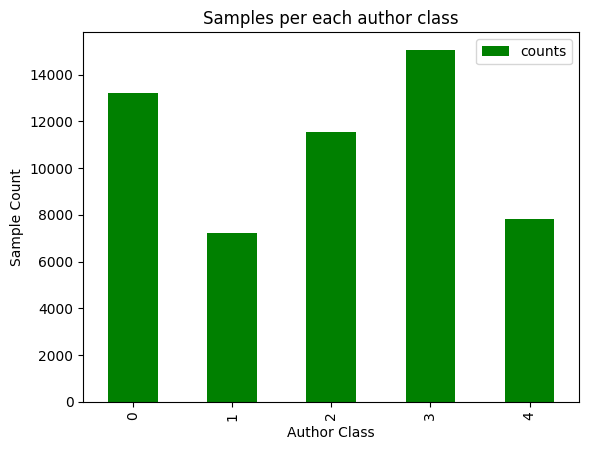

In [ ]:
def plot_author_samples_bar(train_data):
    author_counts = train_data.groupby(train_data.author).size().reset_index(name="counts")
    author_counts.plot.bar(x='author', y='counts', title="Samples per each author class", color='green')
    plt.xlabel('Author Class')
    plt.ylabel('Sample Count')
    plt.show()

plot_author_samples_bar(train)

시각화2 : 데이터 길이 분포

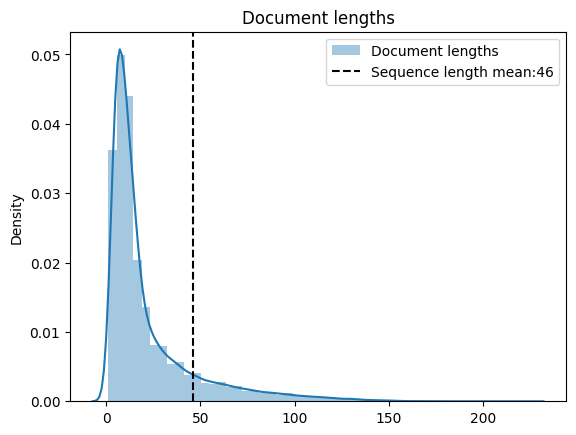

In [ ]:
train['doc_len'] = train.text.apply(lambda words: len(words.split()))

def plot_doc_lengths(dataframe):
    max_seq_len = np.round(dataframe.doc_len.mean() + dataframe.doc_len.std()).astype(int)
    sns.distplot(tuple(dataframe.doc_len), hist=True, kde=True, label='Document lengths')
    plt.axvline(x=max_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{max_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    plt.show()

plot_doc_lengths(train)

시각화3 : 데이터 별 길이 분포

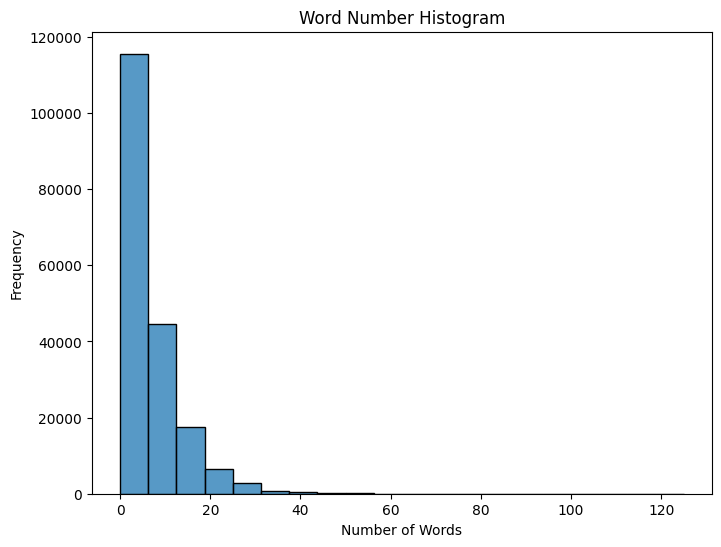

In [ ]:
def plot_word_number_histogram(text_series):
    word_counts = [len(sentence.split()) for text in text_series for sentence in text.split('.')]
    plt.figure(figsize=(8, 6))  # Adjust figure size if needed
    sns.histplot(word_counts, bins=20, palette='viridis', edgecolor='black')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.title('Word Number Histogram')
    plt.show()

plot_word_number_histogram(train['text'])

시각화4 : 각 단어의 길이 분포

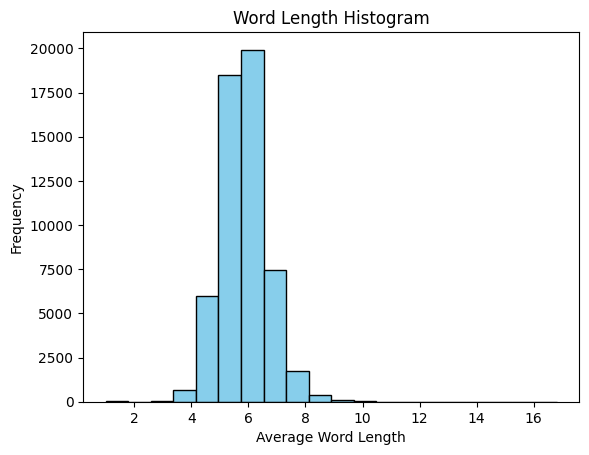

In [ ]:
def plot_word_length_histogram(text_series):
    word_lengths = text_series.str.split().apply(lambda x: [len(word) for word in x]).map(np.mean)
    plt.hist(word_lengths, bins=20, color='skyblue', edgecolor='black')
    plt.xlabel('Average Word Length')
    plt.ylabel('Frequency')
    plt.title('Word Length Histogram')
    plt.show()

plot_word_length_histogram(train['text'])

시각화5 : test 데이터의 길이 분포

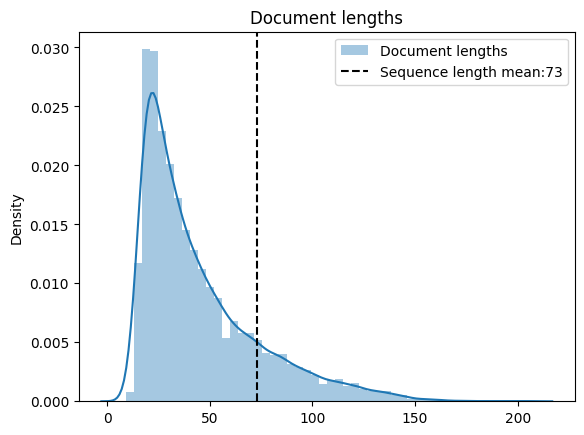

In [ ]:
test['doc_len'] = test.text.apply(lambda words: len(words.split()))

plot_doc_lengths(test)

In [ ]:
train.drop(['doc_len'], axis = 1, inplace = True)
test.drop(['doc_len'], axis = 1, inplace = True)

## 3. 전처리

In [ ]:
# 텍스트에서 구두점을 제외한 단어 목록 반환
def get_words(text):
    words = nltk.tokenize.word_tokenize(text)
    return [word for word in words if not word in string.punctuation]

# 특정 토큰의 개수 셈
def count_tokens(text, tokens):
    words = nltk.tokenize.word_tokenize(text)
    return sum([w in tokens for w in words])

In [ ]:
nltk.download('punkt')

train['num_words']=train['text'].apply(lambda x:len(get_words(x)))
train['num_;']=train['text'].apply(lambda x: count_tokens(x, ';'))
train['num_"']=train['text'].apply(lambda x: count_tokens(x, '”'))
train['num_.']=train['text'].apply(lambda x: count_tokens(x, '.'))
train['num_,']=train['text'].apply(lambda x: count_tokens(x, ','))
train['num_punctuations'] =train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

test['num_words']=test['text'].apply(lambda x:len(get_words(x)))
test['num_;']=test['text'].apply(lambda x: count_tokens(x, ';'))
test['num_"']=test['text'].apply(lambda x: count_tokens(x, '"'))
test['num_.']=test['text'].apply(lambda x: count_tokens(x, '.'))
test['num_,']=test['text'].apply(lambda x: count_tokens(x, ','))
test['num_punctuations'] =test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

In [ ]:
nltk.download('stopwords')

# 불용어 제거해주는 함수
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#전처리 적용
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
# train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)
# test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)
train['text'] = train['text'].apply(remove_stopwords)
test['text'] = test['text'].apply(remove_stopwords)

## 4. 모델링

### 4-1. train/test data 설정

In [ ]:
# 숫자형 피처
cols_to_drop=['text','index']
X_train = train.drop(cols_to_drop+['author'], axis=1)
y_train = train['author']
X_test = test.drop(cols_to_drop, axis=1)

In [ ]:
# 텍스트 피처
text_train = train['text']
text_test = test['text']

### 4-2 토큰화

In [ ]:
# tokenizer에 fit
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

### 4-3. 데이터 sequence 변환 및 padding

In [ ]:
#파라미터 설정
vocab_size = 20000
embedding_dim = 16
max_length = 500
padding_type='post'

In [ ]:
# 데이터를 sequence로 변환해주고 padding 해줍니다.
train_sequences = tokenizer.texts_to_sequences(text_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(text_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

In [ ]:
# 숫자형, 텍스트 피처 합치기
X_train_df = np.concatenate((X_train, train_padded), axis=1)
X_test_df = np.concatenate((X_test, test_padded), axis=1)

### 4-4. StratifiedKFold

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Define the number of splits and epochs
n_splits = 5
num_epochs = 20

# Initialize stratified k-fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

### 4-5. 모델 생성 및 학습

In [ ]:
max_length2 = X_train_df.shape[1]
max_length2

106

In [ ]:
# EarlyStopping callback definition
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Placeholder for test set predictions
pred_list = []

for train_index, val_index in skf.split(train_padded, y_train):
    # NLP 모델 생성
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv1D(64, 5, padding="valid", activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(800, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Fit the model
    history = model.fit(X_train_fold, y_train_fold,
                        epochs=num_epochs, verbose=2,
                        validation_data=(X_val_fold, y_val_fold),
                        callbacks=[early_stopping])

    # Predict values for the test set and store them
    pred = model.predict(test_padded)
    pred_list.append(pred)


Epoch 1/20
1372/1372 - 96s - loss: 1.0077 - accuracy: 0.5957 - val_loss: 0.7180 - val_accuracy: 0.7310 - 96s/epoch - 70ms/step
Epoch 2/20
1372/1372 - 100s - loss: 0.5701 - accuracy: 0.7916 - val_loss: 0.6407 - val_accuracy: 0.7624 - 100s/epoch - 73ms/step
Epoch 3/20
1372/1372 - 98s - loss: 0.4171 - accuracy: 0.8505 - val_loss: 0.6526 - val_accuracy: 0.7664 - 98s/epoch - 71ms/step
Epoch 4/20
1372/1372 - 97s - loss: 0.3451 - accuracy: 0.8757 - val_loss: 0.6955 - val_accuracy: 0.7606 - 97s/epoch - 71ms/step
Epoch 5/20
1372/1372 - 94s - loss: 0.2932 - accuracy: 0.8946 - val_loss: 0.7215 - val_accuracy: 0.7675 - 94s/epoch - 69ms/step
614/614 [==============================] - 8s 13ms/step
Epoch 1/20
1372/1372 - 94s - loss: 1.0077 - accuracy: 0.5983 - val_loss: 0.7265 - val_accuracy: 0.7328 - 94s/epoch - 69ms/step
Epoch 2/20
1372/1372 - 91s - loss: 0.5716 - accuracy: 0.7936 - val_loss: 0.6371 - val_accuracy: 0.7655 - 91s/epoch - 66ms/step
Epoch 3/20
1372/1372 - 91s - loss: 0.4184 - accuracy:

### 4-6. 결과 확인

In [ ]:
pred_list

[array([[2.6124911e-02, 9.1298324e-01, 1.0752710e-02, 4.9209580e-02,
         9.2951348e-04],
        [1.6803342e-03, 9.5620430e-01, 1.5855579e-02, 3.4842347e-03,
         2.2775512e-02],
        [6.0264146e-01, 1.5172465e-01, 1.2224924e-01, 4.5507219e-02,
         7.7877529e-02],
        ...,
        [1.1790693e-02, 9.8557872e-01, 3.2587667e-04, 5.5875606e-04,
         1.7458082e-03],
        [2.4759674e-02, 9.6992004e-01, 5.8568484e-04, 1.3358345e-03,
         3.3987085e-03],
        [9.8016000e-01, 2.2648450e-03, 1.0294878e-02, 4.4495781e-04,
         6.8353927e-03]], dtype=float32),
 array([[1.2825023e-03, 4.1327515e-01, 4.3955860e-01, 1.4435260e-01,
         1.5311757e-03],
        [1.8354535e-02, 9.1019583e-01, 4.0533122e-02, 6.2316549e-03,
         2.4684811e-02],
        [9.4768077e-01, 4.7992345e-02, 1.8639686e-03, 2.3755175e-03,
         8.7444510e-05],
        ...,
        [5.6023459e-04, 9.9927831e-01, 8.2352990e-06, 1.3432186e-04,
         1.8980219e-05],
        [6.224131

In [ ]:
# Average the predictions for the test set
pred = np.mean(pred_list, axis=0)

In [ ]:
# submission
submission[['0','1','2','3','4']] = pred
submission.to_csv('/content/drive/MyDrive/ESAA/OB/data/project2/submission_최종.csv', index = False, encoding = 'utf-8')